In [3]:
%load_ext autoreload
%autoreload 2

# Imports
import numpy as np
import matplotlib.pyplot as plt

# Slef imports
from eclipses import *
from plotting import *
from cpop import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


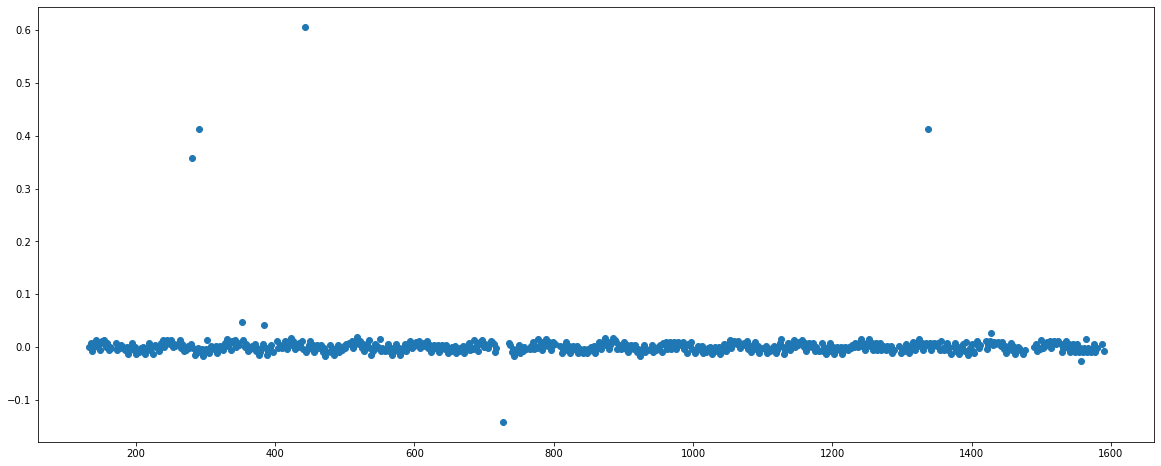

In [17]:
# Getting the Curve
eclipse = get_eclipses("kplr006545018.fits", "../data/combined/")
plt.figure(figsize = (20,8))
plt.scatter(eclipse["time"], getOC(eclipse))

<AxesSubplot:xlabel='time', ylabel='delta'>

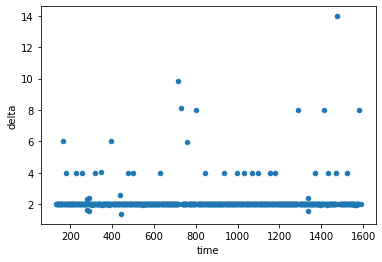

In [11]:
eclipse.plot.scatter(y='delta', x='time')

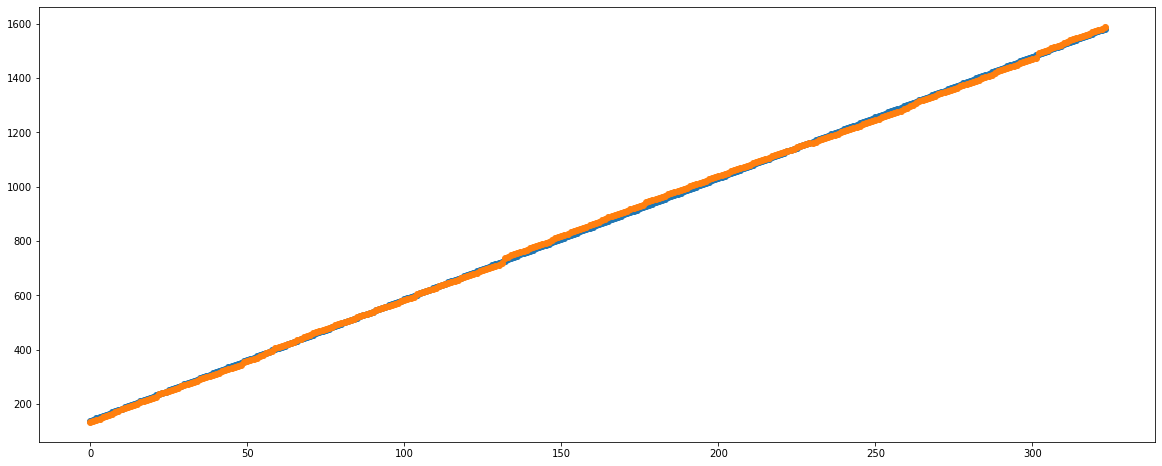